In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'



delim = ';'
user_count = 100
base_path = '/opt/iui-datarelease1-sose2021/'

Xpickle_file = './X.pickle'

ypickle_file = './y.pickle'

In [2]:
def load_pickles():
    _p = open(Xpickle_file, 'rb')
    X = pickle.load(_p)
    _p.close()
        
    _p = open(ypickle_file, 'rb')
    y = pickle.load(_p)
    _p.close()
    
    return (np.asarray(X, dtype=pd.DataFrame), np.asarray(y, dtype=str))

In [3]:
def shorten(npList):
    temp        = npList['Force']
    thresh      = 100
    leeway      = 5
    
    temps_over_T = np.where(temp > thresh)[0]
    return npList[max(temps_over_T[0]-leeway,0):temps_over_T[-1]+leeway]

In [4]:
def load_data():
    if os.path.isfile(Xpickle_file) and os.path.isfile(ypickle_file):
        return load_pickles()
    data = []
    label = []
    for user in range(0, user_count):
        user_path = base_path + str(user) + '/split_letters_csv/'
        for file in os.listdir(user_path):
            file_name = user_path + file
            letter = ''.join(filter(lambda x: x.isalpha(), file))[0]
            data.append(pd.read_csv(file_name, delim))
            label.append(letter)
    return (np.asarray(data, dtype=pd.DataFrame), np.asarray(label, dtype=str), np.asarray(file_name))

In [5]:
%%time
x, y = load_data()


CPU times: user 2.76 s, sys: 205 ms, total: 2.97 s
Wall time: 2.97 s


In [6]:
%%time
f_data = np.array(list(map(shorten, x)))

CPU times: user 3.22 s, sys: 2.07 ms, total: 3.22 s
Wall time: 3.22 s


<timed exec>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


count    13102.000000
mean        61.169058
std         30.698514
min         10.000000
50%         57.000000
95%        102.000000
96%        107.000000
97%        113.000000
98%        127.000000
99%        156.000000
max       1522.000000
dtype: float64

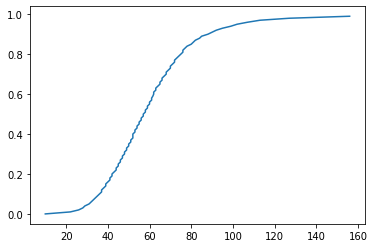

In [7]:
x_len = np.asarray(list(map(len, f_data)))
l = []
sq_xlen = pd.Series(x_len)
ptiles = [x*0.01 for x in range(100)]
for i in ptiles:
    l.append(sq_xlen.quantile(i))
plt.plot(l, ptiles)
sq_xlen.describe(percentiles=[x*0.01 for x in range(95,100)])

In [8]:
thresh_p = 0.99
thresh = int(sq_xlen.quantile(thresh_p))
len_mask = np.where(x_len <= thresh)

x_filter = f_data[len_mask]
y_filter = y[len_mask]



In [9]:
lb = LabelBinarizer()
a = [x.drop(labels='Millis', axis=1) for x in x_filter]
x_filter = pad_sequences(x_filter, dtype=float, padding='post')
yt_filter = lb.fit_transform(y_filter)

In [10]:
%%time
x_train, x_test, y_train, y_test = train_test_split(x_filter, yt_filter, test_size=0.2, random_state=177013)


CPU times: user 34.7 ms, sys: 5.84 ms, total: 40.6 ms
Wall time: 39.2 ms


In [11]:
model = Sequential()

model.add(Flatten(input_shape=x_filter[0].shape))

model.add(BatchNormalization())

model.add(Dense(2200, activation='relu'))

model.add(Dense(1100, activation='relu'))

model.add(Dense(550, activation='relu'))

model.add(Dense(225, activation='relu'))

model.add(Dense(26, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="categorical_crossentropy", 
    metrics=["acc"],
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2340)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2340)              9360      
_________________________________________________________________
dense (Dense)                (None, 2200)              5150200   
_________________________________________________________________
dense_1 (Dense)              (None, 1100)              2421100   
_________________________________________________________________
dense_2 (Dense)              (None, 550)               605550    
_________________________________________________________________
dense_3 (Dense)              (None, 225)               123975    
_________________________________________________________________
dense_4 (Dense)              (None, 26)                5

In [12]:
%%time
model.fit(x_train, y_train, 
          epochs=32,
          batch_size=128,
          shuffle=True,
          verbose=1
         )

Epoch 1/32
82/82 [==============================] - 1s 3ms/step - loss: 2.8553 - acc: 0.1745
Epoch 2/32
82/82 [==============================] - 0s 3ms/step - loss: 1.7793 - acc: 0.4480
Epoch 3/32
82/82 [==============================] - 0s 3ms/step - loss: 1.2391 - acc: 0.6070
Epoch 4/32
82/82 [==============================] - 0s 3ms/step - loss: 0.9623 - acc: 0.7021
Epoch 5/32
82/82 [==============================] - 0s 3ms/step - loss: 0.8489 - acc: 0.7336
Epoch 6/32
82/82 [==============================] - 0s 3ms/step - loss: 0.5827 - acc: 0.8169
Epoch 7/32
82/82 [==============================] - 0s 3ms/step - loss: 0.5208 - acc: 0.8313
Epoch 8/32
82/82 [==============================] - 0s 3ms/step - loss: 0.5864 - acc: 0.8147
Epoch 9/32
82/82 [==============================] - 0s 3ms/step - loss: 0.4101 - acc: 0.8710
Epoch 10/32
82/82 [==============================] - 0s 3ms/step - loss: 0.2856 - acc: 0.9087
Epoch 11/32
82/82 [==============================] - 0s 3ms/step - lo

In [13]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=32)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

lb.inverse_transform(y_test[:3]), lb.inverse_transform(predictions)

Evaluate on test data
82/82 [==============================] - 0s 2ms/step - loss: 1.7331 - acc: 0.7341
test loss, test acc: [1.7330855131149292, 0.7341040372848511]
Generate predictions for 3 samples
predictions shape: (3, 26)


(array(['N', 'U', 'I'], dtype='<U1'), array(['N', 'U', 'I'], dtype='<U1'))

In [14]:
exit()